<a href="https://colab.research.google.com/github/FairuzMaulidya/SC/blob/main/Salinan_PROJEK_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Menyiapkan Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Memuat Data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/SC/ribuan/latih',  # Path data pelatihan
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan batch size
    class_mode='sparse',
    shuffle=True  # Data dilatih dengan shuffle
)

validation_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/SC/ribuan/validasi',  # Path data validasi
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan batch size
    class_mode='sparse',
    shuffle=False  # Validasi tidak perlu shuffle
)

# 3. Membuat Model dengan Transfer Learning (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan beberapa layer pertama base model (misalnya sampai layer ke-100)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Membebaskan beberapa layer terakhir untuk fine-tuning
for layer in base_model.layers[100:]:
    layer.trainable = True

# Membangun model dengan lapisan tambahan
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Tambahkan regularisasi L2
x = Dropout(0.5)(x)  # Regularisasi dropout
x = Dense(10, activation='softmax')(x)  # Sesuaikan dengan jumlah kelas

# Final model
model = Model(inputs=base_model.input, outputs=x)

# 4. Kompilasi Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# 5. Melatih Model
# 5. Melatih Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10  # Jumlah epoch tetap
)

# Menyimpan Model
# Menentukan versi model
version = 7
model_filename = f'model_v{version}.h5'

# Menyimpan model
model.save(model_filename)
print(f"Model disimpan ke: {model_filename}")

Found 1920 images belonging to 10 classes.
Found 480 images belonging to 10 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,026,698 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 809ms/step - accuracy: 0.3608 - loss: 4.2756 - val_accuracy: 0.9000 - val_loss: 2.6266
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 704ms/step - accuracy: 0.8749 - loss: 2.6935 - val_accuracy: 0.9396 - val_loss: 2.4243
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 678ms/step - accuracy: 0.9548 - loss: 2.3798 - val_accuracy: 0.9292 - val_loss: 2.3298
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 681ms/step - accuracy: 0.9687 - loss: 2.2211 - val_accuracy: 0.9625 - val_loss: 2.1414
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - accuracy: 0.9832 - loss: 2.0819 - val_accuracy: 0.9583 - val_loss: 2.0246
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 679ms/step - accuracy: 0.9919 - loss: 1.9622 - val_accuracy: 0.9750 - val_loss: 1.9071
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.9917 - loss: 1.8627 - val_accuracy: 0.9750 - val_loss: 1.8052
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 683ms/step - accuracy: 0.9939 - loss: 1.7513 - val_accu

Model disimpan ke: model_v7.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.9709 - loss: 1.5205
Validation Loss: 1.4849
Validation Accuracy: 0.9896
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step


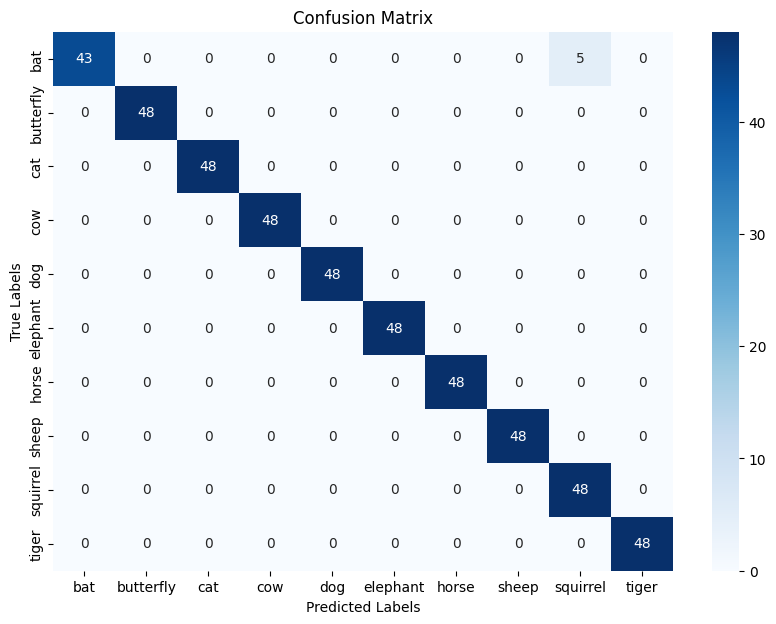

Classification Report:
              precision    recall  f1-score   support

         bat     1.0000    0.8958    0.9451        48
   butterfly     1.0000    1.0000    1.0000        48
         cat     1.0000    1.0000    1.0000        48
         cow     1.0000    1.0000    1.0000        48
         dog     1.0000    1.0000    1.0000        48
    elephant     1.0000    1.0000    1.0000        48
       horse     1.0000    1.0000    1.0000        48
       sheep     1.0000    1.0000    1.0000        48
    squirrel     0.9057    1.0000    0.9505        48
       tiger     1.0000    1.0000    1.0000        48

    accuracy                         0.9896       480
   macro avg     0.9906    0.9896    0.9896       480
weighted avg     0.9906    0.9896    0.9896       480

Error Rate: 0.0104


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Mengevaluasi Model dengan Dataset Validasi
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 2. Mendapatkan Prediksi dan Label Asli
y_true = validation_generator.classes  # Label sebenarnya
y_pred_prob = model.predict(validation_generator, verbose=1)  # Prediksi probabilitas
y_pred = np.argmax(y_pred_prob, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# 3. Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Menampilkan Confusion Matrix Berwarna
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 5. Menghasilkan Laporan Klasifikasi (Precision, Recall, F1 Score)
target_names = list(validation_generator.class_indices.keys())  # Nama kelas
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report:")
print(report)

# 6. Menghitung Error Rate
error_rate = 1 - val_accuracy
print(f"Error Rate: {error_rate:.4f}")